# Modeling

In [76]:
!pwd

/home/jovyan/work/cold_start_models


In [240]:
from sklearn import metrics
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(y_test, y_pred, X):

    mse1 = mse(y_test, y_pred)

    rmse1 = rmse(y_test, y_pred)

    mae1 = mae(y_test, y_pred)

    medae1 = medae(y_test, y_pred)

    R21 = R2(y_test, y_pred)
    
    adj_r2 = 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}\nAdj_R2:  {}".format(mse1, rmse1, R21, mae1, medae1, adj_r2))
    print('-'*30)


def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = y_test
    y_pred = y_pred
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    
    
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))

In [241]:
with open('/home/jovyan/work/cold_start_models/dataset_kp0.pkl', 'rb') as f:
    df_pr = pickle.load(f)
    
df_pr.rename(columns={'user_count_3months': 'target'}, inplace=True)
    
# with open('/home/jovyan/work/cold_start_models/item_coldstart_dataset-avg.pkl', 'rb') as f:
#     df_target = pickle.load(f)

In [242]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age_access_type  8104 non-null   object 
 1   type             8104 non-null   object 
 2   actor_0          8104 non-null   object 
 3   actor_1          8104 non-null   object 
 4   actor_2          8104 non-null   object 
 5   actor_3          8104 non-null   object 
 6   actor_4          8104 non-null   object 
 7   actor_5          8104 non-null   object 
 8   actor_6          8104 non-null   object 
 9   actor_7          8104 non-null   object 
 10  actor_8          8104 non-null   object 
 11  actor_9          8104 non-null   object 
 12  country_0        8104 non-null   object 
 13  director_0       8104 non-null   object 
 14  editor_0         8104 non-null   object 
 15  operator_0       8104 non-null   object 
 16  producer_0       8104 non-null   object 
 17  producer_1    

In [243]:
df_pr.isnull().sum()[df_pr.isnull().sum() > 0]

budget       5658
marketing    7879
rus          4768
world        3939
dtype: int64

In [244]:
df_pr.shape

(8104, 39)

In [245]:
# df_pr.loc[okko_originals, :]['uid'].values

In [246]:
origs = ['ee48def6-c311-4b73-a878-1a5d3d1679a3',
        '9b202b16-55bf-418a-b01d-9f0329b18790',
        '49a3d528-44c0-408e-b6fc-a1507ce7641a',
        'a8749d17-85fc-4ccf-ba56-75991c3a9da4',
        '02eaefe0-296d-4e6f-b52f-2e2507d07103'
                ]

test_mapping = {i: uid for i, uid in enumerate(df_pr[df_pr['uid'].isin(origs)]['uid'].values)}
test_mapping_reverse = {v: k for k, v in test_mapping.items()}
test_scores = {}

In [247]:
test_target = df_pr[df_pr['uid'].isin(origs)][['uid', 'target', 'name']]
test_target['test_id'] = [test_mapping_reverse[uid] for uid in test_target['uid']]
test_target

uid  target               name  test_id
2764  a8749d17-85fc-4ccf-ba56-75991c3a9da4   65842  Всё везде и сразу        0
4993  02eaefe0-296d-4e6f-b52f-2e2507d07103   63298          Приплыли!        1
7472  ee48def6-c311-4b73-a878-1a5d3d1679a3   92510           Чикатило        2
7896  9b202b16-55bf-418a-b01d-9f0329b18790  339083             Манюня        3
8067  49a3d528-44c0-408e-b6fc-a1507ce7641a  415067            Оффлайн        4

In [248]:
urls = {'0': 'https://avatars.mds.yandex.net/get-kinopoisk-image/6201401/4585234d-29b3-430f-be03-d66389fd51d8/1920x',
       '1': 'https://avatars.mds.yandex.net/get-kinopoisk-image/6201401/d5fb835e-de50-4a09-9bd3-e46fa490626b/1920x',
       '2': 'https://avatars.mds.yandex.net/get-kinopoisk-image/1900788/3685d63e-0b6e-423d-9d0b-0c17c219acf9/1920x',
       '3': 'https://avatars.mds.yandex.net/get-kinopoisk-image/4303601/0cb1cc7b-c479-407d-a4ec-da9a2a2d4856/1920x',
       '4': 'https://avatars.mds.yandex.net/get-kinopoisk-image/4303601/91948f6c-f0fc-4791-8792-57e8898e608f/1920x'}

In [249]:
scores = {test_id: {'watches': target} for test_id, target in zip(test_target['test_id'], test_target['target']) }

In [250]:
scores

{0: {'watches': 65842},
 1: {'watches': 63298},
 2: {'watches': 92510},
 3: {'watches': 339083},
 4: {'watches': 415067}}

In [251]:
# new = df_pr[df_pr['release_year'] == 2022]
# new[new['user_count_3months'] > 3000][['name', 'release_year', 'country_0', 'uid', 'user_count_3months', 'type']].sort_values('user_count_3months')

# 0

In [252]:
df_pr.columns

Index(['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
       'genre_1', 'genre_2', 'budget', 'marketing', 'rus', 'world', 'duration',
       'release_year', 'target', 'uid', 'name'],
      dtype='object')

In [253]:
cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
               'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
               'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
               'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
               'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
               'genre_1', 'genre_2']
num_features = ['budget', 'marketing', 'rus', 'world', 'duration']


df_pr[cat_features] = df_pr[cat_features].astype(str)

In [91]:
okko_ids = df_pr[df_pr['uid'].isin(origs)].index

In [194]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_pr_short = df_pr[df_pr['target'] > 100]
X, y = df_pr_short[cat_features+num_features], df_pr_short['target']


orig_ids = df_pr_short[df_pr_short['uid'].isin(origs)].index

# X.drop(orig_ids, axis=0, inplace=True)
# y.drop(orig_ids, axis=0, inplace=True)

# [df_pr_short['release_year'].astype(float) < 2022]
df_train, df_test = df_pr_short[df_pr_short['release_year'].astype(float) < 2022],  df_pr_short[df_pr_short['release_year'].astype(float) == 2022] # , y[df_pr['release_year'].astype(float) < 2022],  y[df_pr['release_year'].astype(float) >= 2021]
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42, shuffle=True)
df_test = pd.concat([df_test, df_pr_short[df_pr_short['uid'].isin(origs)]])
df_test.drop_duplicates(inplace=True)

X_train, y_train = df_train[cat_features+num_features], df_train['target']
X_val, y_val = df_val[cat_features+num_features], df_val['target']
X_test, y_test = df_test[cat_features+num_features], df_test['target']


scaler.fit(np.array(y_train).reshape(-1, 1))

y_test_scale, y_val_scale, y_train_scale = scaler.transform(np.array(y_test).reshape(-1, 1)).flatten(), scaler.transform(np.array(y_val).reshape(-1, 1)).flatten(), scaler.transform(np.array(y_train).reshape(-1, 1)).flatten()

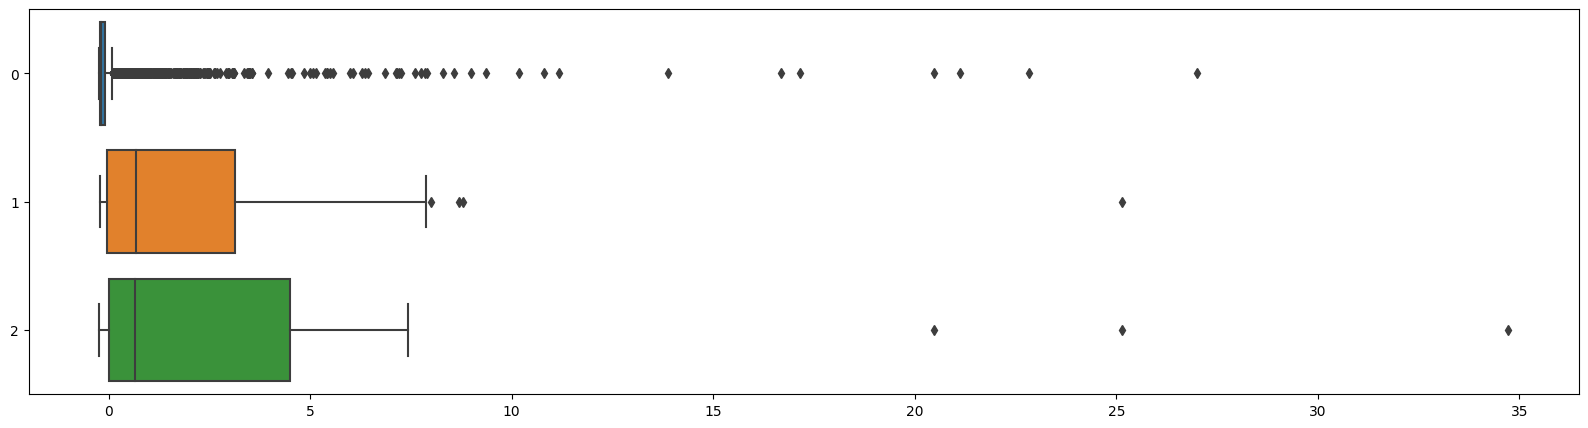

In [170]:
plt.figure(figsize=(20, 5))
sns.boxplot([y_train_scale, y_val_scale, y_test_scale], orient='h')
plt.show()

In [93]:
X_train.columns

Index(['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
       'genre_1', 'genre_2', 'budget', 'marketing', 'rus', 'world',
       'duration'],
      dtype='object')

In [154]:
X_train.shape, X_val.shape, X_test.shape, y_test.shape

((5444, 35), (36, 35), (39, 35), (39,))

In [184]:
y_test_scale

array([ 4.89329845e-02,  7.91278106e-01,  6.13804620e+00,  1.38997589e-01,
        2.85267531e+00,  1.30559765e-01,  4.59575864e+00,  1.32359477e+00,
        3.29744904e-02, -1.09062221e-01, -1.11141106e-01, -1.95886212e-01,
        5.13376166e+00, -7.00525691e-02,  1.49467472e+00, -1.46564173e-02,
       -2.28353493e-01,  7.33799044e+00,  3.23162279e-01,  7.41490916e+00,
       -2.13556729e-01, -4.44333775e-02,  6.04174495e+00,  3.47222771e+01,
       -1.76075668e-01,  8.96200619e-01,  6.50708842e-01,  1.44011369e-01,
        5.97452718e-01,  3.62485853e+00,  3.78040799e+00,  4.34873827e+00,
       -2.24929448e-01,  1.68591118e-01,  4.41660773e+00,  6.37908927e-02,
        5.41098700e+00,  2.04873616e+01,  2.51333011e+01])

In [95]:
df_pr_short[df_pr_short['uid'].isin(origs)][['genre_0', 'director_0', 'actor_0', 'country_0']]

genre_0       director_0            actor_0 country_0
2764    Sci-Fi         Дэн Кван         Мишель Йео       usa
4993    Comedy   Юрий Ярушников     Владимир Яглыч    russia
7472  Thriller  Сарик Андреасян     Дмитрий Нагиев    russia
7896    Comedy    Арман Марутян  Екатерина Темнова    russia
8067  Thriller   Кирилл Плетнёв     Никита Ефремов    russia

In [96]:
df_pr_short.columns

Index(['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
       'genre_1', 'genre_2', 'budget', 'marketing', 'rus', 'world', 'duration',
       'release_year', 'target', 'uid', 'name'],
      dtype='object')

In [161]:
train_dataset = cat.Pool(X_train, y_train_scale,
                         cat_features=cat_features,   
                        ) 
# test_dataset = cat.Pool(X_test, y_test,
#                          cat_features=cat_features,
#                        )
val_dataset = cat.Pool(X_val, y_val_scale,
                       cat_features=cat_features,
                      )

In [162]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
    'iterations': 3972,
     'learning_rate': 0.0352664963637796,
     'depth': 8,
     'l2_leaf_reg': 0.33177691943395776,
    
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
   eval_set=val_dataset,
   early_stopping_rounds=150,
    verbose=100,
    plot=False
)

0:	learn: 0.3135233	test: 2.7136901	best: 2.7136901 (0)	total: 26ms	remaining: 1m 43s
100:	learn: 0.2672707	test: 2.5990723	best: 2.5990723 (100)	total: 2.56s	remaining: 1m 38s
200:	learn: 0.2513836	test: 2.5622542	best: 2.5622542 (200)	total: 5.18s	remaining: 1m 37s
300:	learn: 0.2401636	test: 2.5537109	best: 2.5492838 (254)	total: 7.82s	remaining: 1m 35s
400:	learn: 0.2296584	test: 2.5376248	best: 2.5376248 (400)	total: 10.5s	remaining: 1m 33s
500:	learn: 0.2208027	test: 2.5463581	best: 2.5325618 (434)	total: 13.3s	remaining: 1m 32s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 2.5325618
bestIteration = 434

Shrink model to first 435 iterations.


In [208]:
# cat_model.save_model('kp0_honest_scale')
cat_model = cat.CatBoostRegressor(**cat_params)
cat_model.load_model('kp0_honest_scale')

y_pred = cat_model.predict(X_test)

In [209]:
y_pred

array([ 0.02894696, -0.10547291,  1.47641549,  0.07949751,  0.00829188,
       -0.17098369, -0.17588077,  0.80899909, -0.18213338,  0.03975789,
       -0.01031389, -0.14194841,  0.45899017,  0.02613173,  0.74633909,
       -0.02219191,  0.02617714,  0.58643978, -0.11455237,  0.02287462,
       -0.15512992, -0.06980347,  1.26134121,  0.47982074, -0.14562748,
       -0.06001599,  1.74641719, -0.25856022,  0.01193248,  0.90519347,
        0.08548138,  0.04062003,  0.00210514,  0.33146512,  0.10103649,
        0.33329822,  1.84628795,  1.85196456,  1.78643107])

In [210]:
calc_metrics(y_test_scale, y_pred, X)

*** VAL **: 
MSE:   59.954054431114365
RMSE:  7.743000350711239
R2:    -0.1436871030544289
MAE:   3.5480298809922797
MedAE: 0.5855202414017467
Adj_R2:  -0.15099167396809765
------------------------------


In [211]:
calc_metrics(y_train_scale, cat_model.predict(X_train), X)

*** VAL **: 
MSE:   0.7681638950943379
RMSE:  0.8764495964368618
R2:    0.23183610490566187
MAE:   0.2551427210517264
MedAE: 0.11034738070071329
Adj_R2:  0.22692994864137328
------------------------------


In [212]:
calc_metrics(y_val_scale, cat_model.predict(X_val), X)

*** VAL **: 
MSE:   25.85760957143582
RMSE:  5.085037814159873
R2:    -0.14463342937442825
MAE:   2.532562845942827
MedAE: 0.5423240332588173
Adj_R2:  -0.15194404434306064
------------------------------


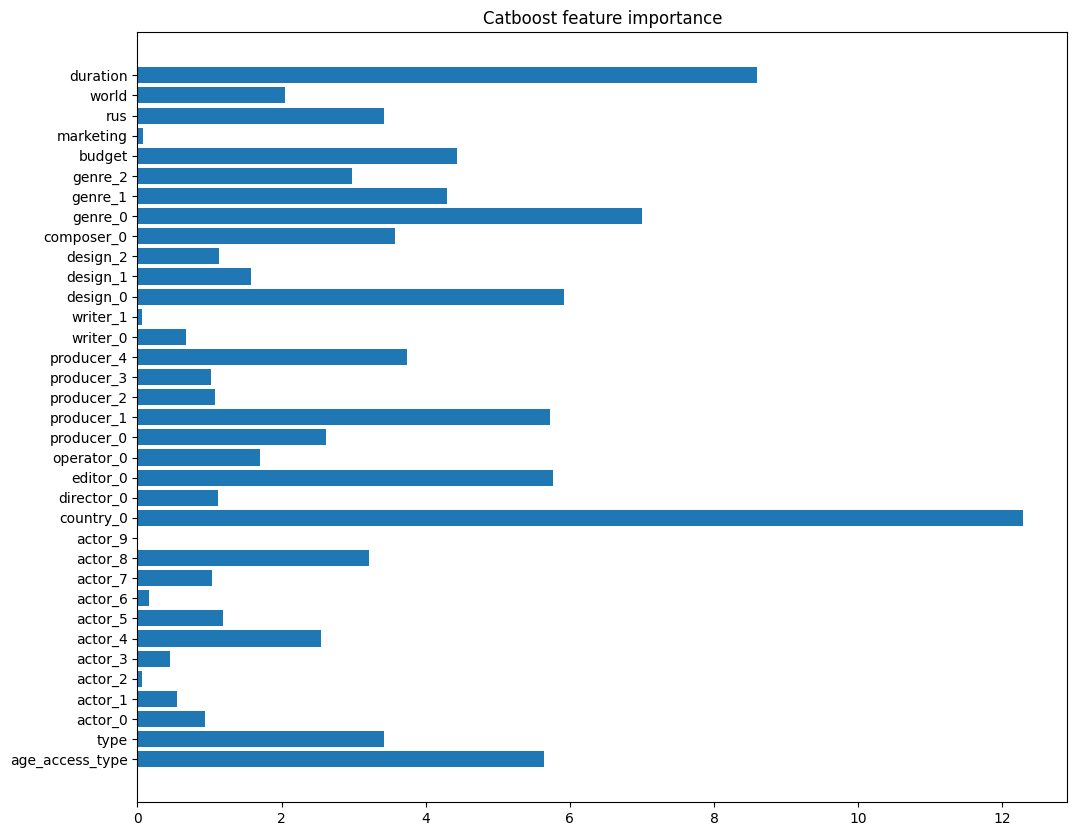

In [213]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

In [237]:
draw_target_distr(y_test, pd.Series(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()), save_fig=False, file_name='cat_distribution')

NameError: name 'y_pred_scale' is not defined

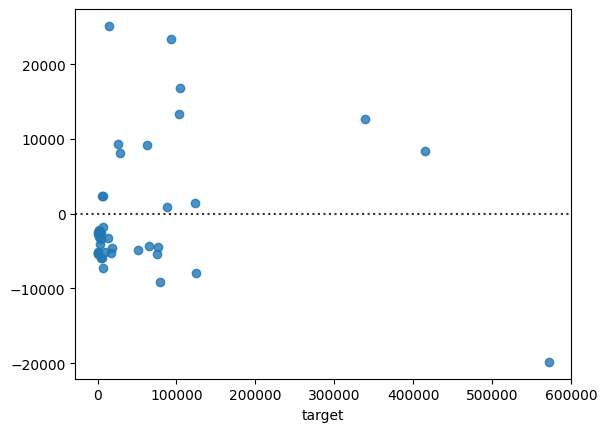

In [239]:
draw_residuals(y_test, pd.Series(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()), save_fig=False)

In [216]:
len(y_pred[y_pred <= 0])

13

In [228]:
test_review = pd.concat([X_test.merge(df_pr)[['uid', 'name', 'target']],  pd.Series(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()).apply(int)], axis=1)
test_review.columns = columns=['uid', 'name', 'target', 'y_pred']

In [229]:
test_review[test_review['uid'].isin(origs)]

uid               name  target  y_pred
29  02eaefe0-296d-4e6f-b52f-2e2507d07103          Приплыли!   63298   18818
30  a8749d17-85fc-4ccf-ba56-75991c3a9da4  Всё везде и сразу   65842    5411
36  ee48def6-c311-4b73-a878-1a5d3d1679a3           Чикатило   92510   34209
37  9b202b16-55bf-418a-b01d-9f0329b18790             Манюня  339083   34302
38  49a3d528-44c0-408e-b6fc-a1507ce7641a            Оффлайн  415067   33230

In [219]:
y_pred

array([ 0.02894696, -0.10547291,  1.47641549,  0.07949751,  0.00829188,
       -0.17098369, -0.17588077,  0.80899909, -0.18213338,  0.03975789,
       -0.01031389, -0.14194841,  0.45899017,  0.02613173,  0.74633909,
       -0.02219191,  0.02617714,  0.58643978, -0.11455237,  0.02287462,
       -0.15512992, -0.06980347,  1.26134121,  0.47982074, -0.14562748,
       -0.06001599,  1.74641719, -0.25856022,  0.01193248,  0.90519347,
        0.08548138,  0.04062003,  0.00210514,  0.33146512,  0.10103649,
        0.33329822,  1.84628795,  1.85196456,  1.78643107])

### Not scaled

In [196]:
cat_model = cat.CatBoostRegressor(**cat_params)
cat_model.load_model('kp0_honest_finetuned')

y_pred = cat_model.predict(X_test)

In [197]:
calc_metrics(y_test, cat_model.predict(X_test), X)

*** VAL **: 
MSE:   15316490921.996298
RMSE:  123759.81141710057
R2:    -0.09232215648860853
MAE:   57181.687877603756
MedAE: 11620.66911006867
Adj_R2:  -0.09929866661216713
------------------------------


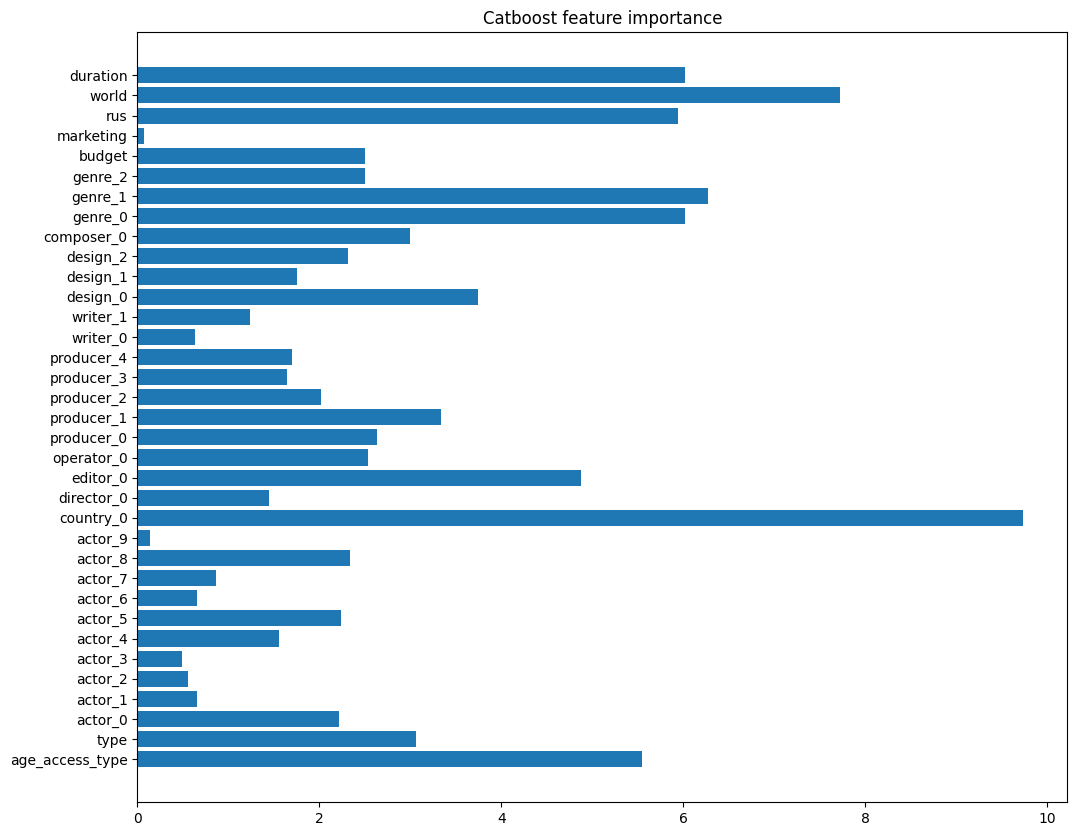

In [198]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

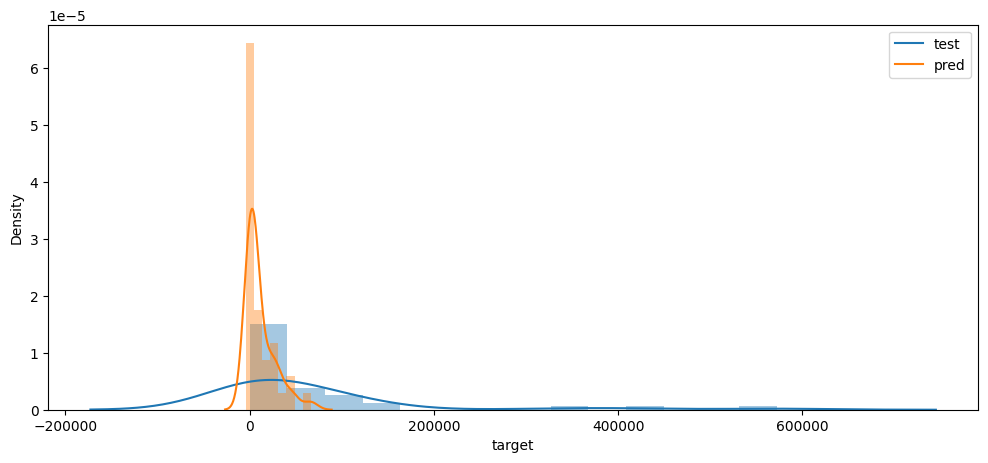

In [199]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

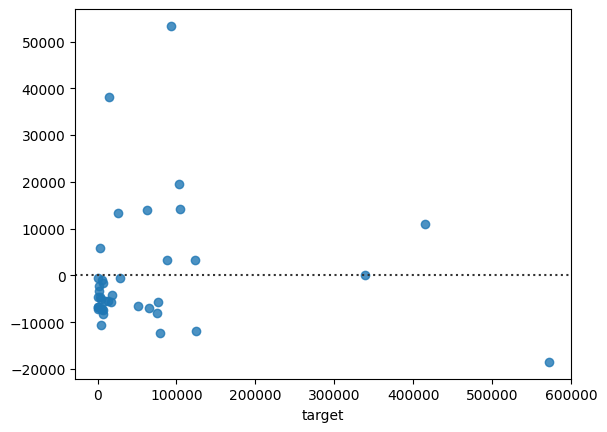

In [201]:
draw_residuals(y_test, y_pred, save_fig=False)

In [202]:
len(y_pred[y_pred <= 0])

9

In [203]:
df_pr.columns

Index(['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
       'genre_1', 'genre_2', 'budget', 'marketing', 'rus', 'world', 'duration',
       'release_year', 'target', 'uid', 'name'],
      dtype='object')

In [204]:
test_review = pd.concat([X_test.merge(df_pr)[['uid', 'name', 'target']], pd.Series(y_pred).apply(int)], axis=1)
test_review.columns = columns=['uid', 'name', 'target', 'y_pred']

In [205]:
# without standardization
test_review[test_review['uid'].isin(origs)]

uid               name  target  y_pred
29  02eaefe0-296d-4e6f-b52f-2e2507d07103          Приплыли!   63298   25034
30  a8749d17-85fc-4ccf-ba56-75991c3a9da4  Всё везде и сразу   65842    4235
36  ee48def6-c311-4b73-a878-1a5d3d1679a3           Чикатило   92510   66316
37  9b202b16-55bf-418a-b01d-9f0329b18790             Манюня  339083   29845
38  49a3d528-44c0-408e-b6fc-a1507ce7641a            Оффлайн  415067   45917

# Tuning

In [ ]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,
                         
                        ) 

parameters_distr = {'depth': randint(5, 10),
                    'learning_rate': uniform(0.01, 0.3),
                    'iterations': randint(500, 10000),
                    'l2_leaf_reg':  uniform(0.01, 0.5)
                     }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, scoring='neg_mean_squared_error',
                          cv=5, n_jobs=-1, verbose=0)

grid.fit(X_train, y_train)

cat_model = grid.best_estimator_
# cat_model.save_model('kp0_honest_finetuned')

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, emb

0:	learn: 4353.7977991	total: 469ms	remaining: 23m 41s
1:	learn: 4349.6626305	total: 1.12s	remaining: 28m 13s
2:	learn: 4346.7513967	total: 1.98s	remaining: 33m 19s
3:	learn: 4343.4899698	total: 2.63s	remaining: 33m 14s
4:	learn: 4339.6521006	total: 3.08s	remaining: 31m 8s
5:	learn: 4336.0146296	total: 3.46s	remaining: 29m 6s
6:	learn: 4333.8363555	total: 3.62s	remaining: 26m 6s
7:	learn: 4328.9660522	total: 4.11s	remaining: 25m 53s
8:	learn: 4325.4850636	total: 5.01s	remaining: 28m 4s
9:	learn: 4322.5403061	total: 5.65s	remaining: 28m 26s
10:	learn: 4318.6228826	total: 6.14s	remaining: 28m 6s
11:	learn: 4315.2080612	total: 6.73s	remaining: 28m 14s
12:	learn: 4311.6417726	total: 7.26s	remaining: 28m 7s
13:	learn: 4309.1042174	total: 8.05s	remaining: 28m 55s
14:	learn: 4305.5670805	total: 9.31s	remaining: 31m 13s
15:	learn: 4302.8183238	total: 9.71s	remaining: 30m 30s
16:	learn: 4300.3368082	total: 10.4s	remaining: 30m 36s
17:	learn: 4297.3413237	total: 11.2s	remaining: 31m 9s
18:	learn

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


2774:	learn: 1402.7637340	total: 57m 17s	remaining: 2h 19s
2775:	learn: 1402.3395294	total: 57m 18s	remaining: 2h 19s
2776:	learn: 1402.0925148	total: 57m 19s	remaining: 2h 17s
2777:	learn: 1402.1966658	total: 57m 21s	remaining: 2h 18s
2778:	learn: 1401.7753835	total: 57m 22s	remaining: 2h 16s
2779:	learn: 1401.5314871	total: 57m 23s	remaining: 2h 14s
2780:	learn: 1400.6853802	total: 57m 24s	remaining: 2h 12s
2781:	learn: 1400.5303581	total: 57m 25s	remaining: 2h 10s
2782:	learn: 1399.7853795	total: 57m 26s	remaining: 2h 7s
2783:	learn: 1399.4193895	total: 57m 26s	remaining: 2h 5s
2784:	learn: 1399.2221157	total: 57m 27s	remaining: 2h 3s
2785:	learn: 1398.7112270	total: 57m 28s	remaining: 2h 1s
2786:	learn: 1398.7565483	total: 57m 29s	remaining: 1h 59m 59s
2787:	learn: 1398.7925436	total: 57m 30s	remaining: 1h 59m 58s
2788:	learn: 1398.0372329	total: 57m 31s	remaining: 1h 59m 56s
2789:	learn: 1397.3042723	total: 57m 32s	remaining: 1h 59m 55s
2790:	learn: 1396.8580392	total: 57m 33s	rem

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


1214:	learn: 183.5316230	total: 54m 17s	remaining: 4h 23m 41s
1215:	learn: 182.9646860	total: 54m 20s	remaining: 4h 23m 40s
1216:	learn: 182.2269183	total: 54m 23s	remaining: 4h 23m 41s
1217:	learn: 181.7928466	total: 54m 27s	remaining: 4h 23m 43s
1218:	learn: 181.4769960	total: 54m 29s	remaining: 4h 23m 39s
1219:	learn: 181.0457534	total: 54m 31s	remaining: 4h 23m 35s
1220:	learn: 180.5370210	total: 54m 34s	remaining: 4h 23m 33s
1221:	learn: 180.2093785	total: 54m 36s	remaining: 4h 23m 27s
1222:	learn: 179.9913957	total: 54m 38s	remaining: 4h 23m 21s
1223:	learn: 179.2784464	total: 54m 41s	remaining: 4h 23m 18s
1224:	learn: 179.0538957	total: 54m 44s	remaining: 4h 23m 17s
1225:	learn: 178.7223142	total: 54m 46s	remaining: 4h 23m 12s
1226:	learn: 178.3765398	total: 54m 48s	remaining: 4h 23m 5s
1227:	learn: 178.0078748	total: 54m 50s	remaining: 4h 23m
1228:	learn: 177.1586639	total: 54m 54s	remaining: 4h 23m 2s
1229:	learn: 177.0892434	total: 54m 55s	remaining: 4h 22m 53s
1230:	learn: 1

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


1214:	learn: 148.1073191	total: 54m 33s	remaining: 58m 30s
1215:	learn: 147.5287688	total: 54m 36s	remaining: 58m 28s
1216:	learn: 146.5920265	total: 54m 38s	remaining: 58m 24s
1217:	learn: 146.1400986	total: 54m 40s	remaining: 58m 21s
1218:	learn: 145.8257759	total: 54m 43s	remaining: 58m 18s
1219:	learn: 145.1119563	total: 54m 45s	remaining: 58m 15s
1220:	learn: 144.8609624	total: 54m 49s	remaining: 58m 14s
1221:	learn: 144.7870505	total: 54m 52s	remaining: 58m 11s
1222:	learn: 144.3844187	total: 54m 55s	remaining: 58m 9s
1223:	learn: 143.7687879	total: 55m	remaining: 58m 9s
1224:	learn: 143.3910115	total: 55m 2s	remaining: 58m 6s
1225:	learn: 143.1135582	total: 55m 5s	remaining: 58m 3s
1226:	learn: 142.9022320	total: 55m 6s	remaining: 57m 59s
1227:	learn: 142.5612018	total: 55m 10s	remaining: 57m 57s
1228:	learn: 142.0524694	total: 55m 12s	remaining: 57m 54s
1229:	learn: 141.6522380	total: 55m 15s	remaining: 57m 52s
1230:	learn: 141.4557648	total: 55m 18s	remaining: 57m 49s
1231:	le

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


2906:	learn: 1610.5403189	total: 58m 58s	remaining: 1h 55m 34s
2907:	learn: 1609.8502596	total: 59m	remaining: 1h 55m 34s
2908:	learn: 1609.6680760	total: 59m 1s	remaining: 1h 55m 33s
2909:	learn: 1608.1858168	total: 59m 3s	remaining: 1h 55m 33s
2910:	learn: 1607.5770384	total: 59m 4s	remaining: 1h 55m 31s
2911:	learn: 1607.2495263	total: 59m 5s	remaining: 1h 55m 31s
2912:	learn: 1606.7363209	total: 59m 6s	remaining: 1h 55m 28s
2913:	learn: 1606.4995308	total: 59m 8s	remaining: 1h 55m 28s
2914:	learn: 1605.8551767	total: 59m 8s	remaining: 1h 55m 25s
2915:	learn: 1605.5038500	total: 59m 9s	remaining: 1h 55m 23s
2916:	learn: 1604.5677535	total: 59m 11s	remaining: 1h 55m 23s
2917:	learn: 1604.5484800	total: 59m 12s	remaining: 1h 55m 22s
2918:	learn: 1604.3457136	total: 59m 13s	remaining: 1h 55m 21s
2919:	learn: 1603.6056920	total: 59m 16s	remaining: 1h 55m 22s
2920:	learn: 1603.3728264	total: 59m 17s	remaining: 1h 55m 21s
2921:	learn: 1603.7339973	total: 59m 19s	remaining: 1h 55m 21s
2922

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


1540:	learn: 57.3777147	total: 1h 9m 46s	remaining: 8m 11s
1541:	learn: 57.2403379	total: 1h 9m 49s	remaining: 8m 8s
1542:	learn: 57.1987060	total: 1h 9m 50s	remaining: 8m 6s
1543:	learn: 57.0986424	total: 1h 9m 53s	remaining: 8m 3s
1544:	learn: 57.0402875	total: 1h 9m 56s	remaining: 8m
1545:	learn: 56.9622426	total: 1h 9m 59s	remaining: 7m 58s
1546:	learn: 56.8816705	total: 1h 10m 2s	remaining: 7m 55s
1547:	learn: 56.7366339	total: 1h 10m 6s	remaining: 7m 52s
1548:	learn: 56.6184072	total: 1h 10m 9s	remaining: 7m 50s
1549:	learn: 56.4998728	total: 1h 10m 11s	remaining: 7m 47s
1550:	learn: 56.4541555	total: 1h 10m 14s	remaining: 7m 44s
1551:	learn: 56.3980313	total: 1h 10m 16s	remaining: 7m 41s
1552:	learn: 56.3730995	total: 1h 10m 18s	remaining: 7m 39s
1553:	learn: 56.0668576	total: 1h 10m 21s	remaining: 7m 36s
1554:	learn: 55.7486346	total: 1h 10m 24s	remaining: 7m 33s
1555:	learn: 55.7088472	total: 1h 10m 28s	remaining: 7m 31s
1556:	learn: 55.6194378	total: 1h 10m 31s	remaining: 7m 

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


1979:	learn: 1928.1501854	total: 1h 12m 40s	remaining: 2h 30m 46s
1980:	learn: 1927.1530398	total: 1h 12m 42s	remaining: 2h 30m 44s
1981:	learn: 1926.7230352	total: 1h 12m 44s	remaining: 2h 30m 42s
1982:	learn: 1926.1299588	total: 1h 12m 46s	remaining: 2h 30m 39s
1983:	learn: 1925.6033825	total: 1h 12m 48s	remaining: 2h 30m 35s
1984:	learn: 1925.0592546	total: 1h 12m 50s	remaining: 2h 30m 33s
1985:	learn: 1924.3538586	total: 1h 12m 52s	remaining: 2h 30m 31s
1986:	learn: 1923.3393148	total: 1h 12m 54s	remaining: 2h 30m 29s
1987:	learn: 1921.6453152	total: 1h 12m 56s	remaining: 2h 30m 26s
1988:	learn: 1920.6787131	total: 1h 12m 58s	remaining: 2h 30m 22s
1989:	learn: 1919.9092026	total: 1h 12m 59s	remaining: 2h 30m 19s
1990:	learn: 1918.3308906	total: 1h 13m 2s	remaining: 2h 30m 19s
1991:	learn: 1917.3156271	total: 1h 13m 4s	remaining: 2h 30m 15s
1992:	learn: 1915.8850372	total: 1h 13m 6s	remaining: 2h 30m 12s
1993:	learn: 1915.1442190	total: 1h 13m 7s	remaining: 2h 30m 8s
1994:	learn: 19

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


292:	learn: 3686.2958387	total: 11m 49s	remaining: 5h 18m 56s
293:	learn: 3684.2890886	total: 11m 51s	remaining: 5h 18m 56s
294:	learn: 3682.9803859	total: 11m 54s	remaining: 5h 18m 58s
295:	learn: 3675.6926619	total: 11m 57s	remaining: 5h 19m 9s
296:	learn: 3673.2187787	total: 11m 59s	remaining: 5h 19m
297:	learn: 3672.6424605	total: 12m 2s	remaining: 5h 19m 5s
298:	learn: 3667.7962171	total: 12m 4s	remaining: 5h 18m 56s
299:	learn: 3667.2956643	total: 12m 5s	remaining: 5h 18m 34s
300:	learn: 3665.3494224	total: 12m 8s	remaining: 5h 18m 27s
301:	learn: 3663.4606895	total: 12m 12s	remaining: 5h 19m 11s
302:	learn: 3660.9125485	total: 12m 14s	remaining: 5h 19m 10s
303:	learn: 3659.6997076	total: 12m 16s	remaining: 5h 18m 57s
304:	learn: 3650.4973032	total: 12m 18s	remaining: 5h 18m 48s
305:	learn: 3647.3753846	total: 12m 22s	remaining: 5h 19m 16s
306:	learn: 3644.6705215	total: 12m 24s	remaining: 5h 19m 12s
307:	learn: 3642.9447119	total: 12m 27s	remaining: 5h 19m 23s
308:	learn: 3643.1

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


1993:	learn: 122.3199544	total: 1h 13m 47s	remaining: 4h 36m 11s
1994:	learn: 122.2161212	total: 1h 13m 50s	remaining: 4h 36m 11s
1995:	learn: 122.1162615	total: 1h 13m 52s	remaining: 4h 36m 10s
1996:	learn: 122.0318181	total: 1h 13m 55s	remaining: 4h 36m 8s
1997:	learn: 121.8907758	total: 1h 13m 56s	remaining: 4h 36m 3s
1998:	learn: 121.7182947	total: 1h 13m 58s	remaining: 4h 35m 58s
1999:	learn: 121.5509040	total: 1h 13m 59s	remaining: 4h 35m 54s
2000:	learn: 121.5227981	total: 1h 14m 2s	remaining: 4h 35m 52s
2001:	learn: 121.2500102	total: 1h 14m 4s	remaining: 4h 35m 52s
2002:	learn: 121.2562085	total: 1h 14m 6s	remaining: 4h 35m 48s
2003:	learn: 121.1072481	total: 1h 14m 8s	remaining: 4h 35m 45s
2004:	learn: 120.8812850	total: 1h 14m 10s	remaining: 4h 35m 39s
2005:	learn: 120.6328980	total: 1h 14m 12s	remaining: 4h 35m 39s
2006:	learn: 120.5207889	total: 1h 14m 14s	remaining: 4h 35m 34s
2007:	learn: 120.3457563	total: 1h 14m 16s	remaining: 4h 35m 33s
2008:	learn: 120.1762131	total:

In [128]:
cat_model = cat.CatBoostRegressor(**cat_params)
cat_model.load_model('kp0_honest_finetuned')

In [129]:
cat_model.get_params()

{'loss_function': 'RMSE',
 'random_seed': 321,
 'verbose': 1,
 'eval_metric': 'MAE',
 'allow_writing_files': False,
 'cat_features': ['age_access_type',
  'type',
  'actor_0',
  'actor_1',
  'actor_2',
  'actor_3',
  'actor_4',
  'actor_5',
  'actor_6',
  'actor_7',
  'actor_8',
  'actor_9',
  'country_0',
  'director_0',
  'editor_0',
  'operator_0',
  'producer_0',
  'producer_1',
  'producer_2',
  'producer_3',
  'producer_4',
  'writer_0',
  'writer_1',
  'design_0',
  'design_1',
  'design_2',
  'composer_0',
  'genre_0',
  'genre_1',
  'genre_2'],
 'iterations': 4098,
 'l2_leaf_reg': 0.1400308712,
 'depth': 8,
 'learning_rate': 0.0336926462}

In [130]:
y_pred = cat_model.predict(X_test)

In [131]:
y_pred

array([ 1.83656061e+03,  2.08199010e+03,  2.80542495e+04, -3.76843386e+02,
        3.65897464e+03, -1.15312584e+02, -2.08846633e+02,  2.17063010e+04,
       -3.71604455e+03,  3.54936070e+03,  4.46998414e+03, -9.56714759e+01,
        1.59151000e+04,  1.26429485e+04,  8.08327846e+03, -3.93200807e+02,
        1.96716119e+03,  1.83681705e+04,  1.72302753e+03,  3.38141914e+03,
       -2.36069617e+01,  2.25054493e+03,  3.32481276e+04,  2.72118373e+04,
       -4.47113374e+02,  3.75417686e+03,  4.57066235e+04, -1.26865681e+03,
        2.16433089e+03,  2.50343350e+04,  4.23506709e+03,  3.77418008e+03,
        6.00405513e+03,  5.37094452e+03,  6.13587545e+03,  6.05286596e+03,
        6.63160896e+04,  2.98456426e+04,  4.59172451e+04])

<AxesSubplot: >

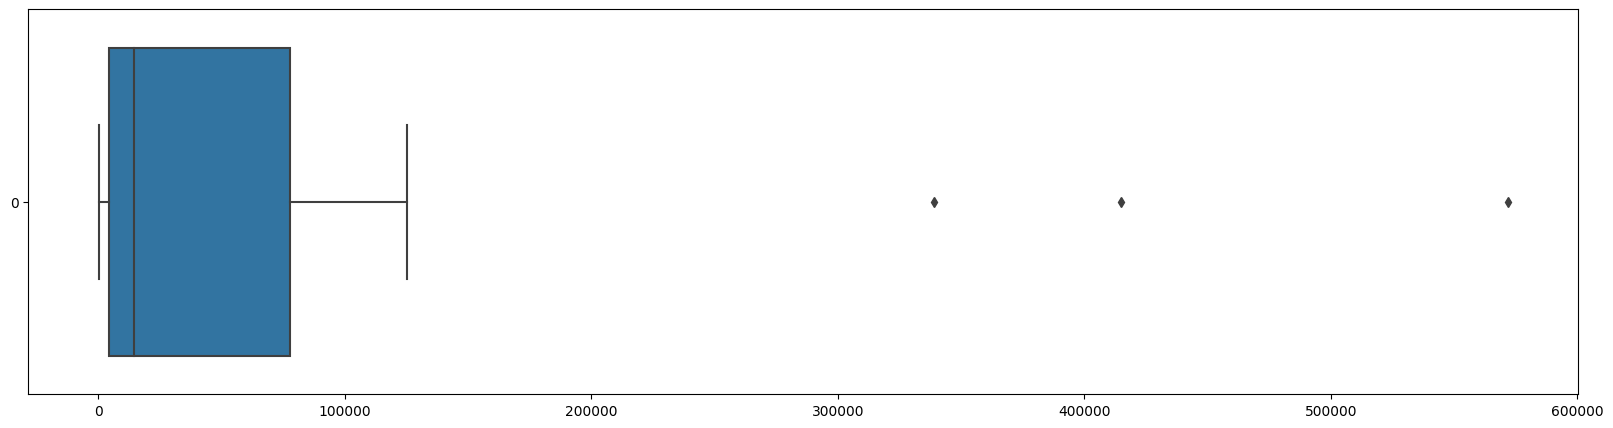

In [132]:
plt.figure(figsize=(20, 5))
sns.boxplot(y_test.values, orient='h')

In [133]:
calc_metrics(y_test[y_test < 100000], y_pred[y_test < 100000], X)

*** VAL **: 
MSE:   1002233751.4657423
RMSE:  31658.075612167937
R2:    -0.10581640531042558
MAE:   19797.859968922603
MedAE: 7606.8146403446335
Adj_R2:  -0.1128791013297441
------------------------------


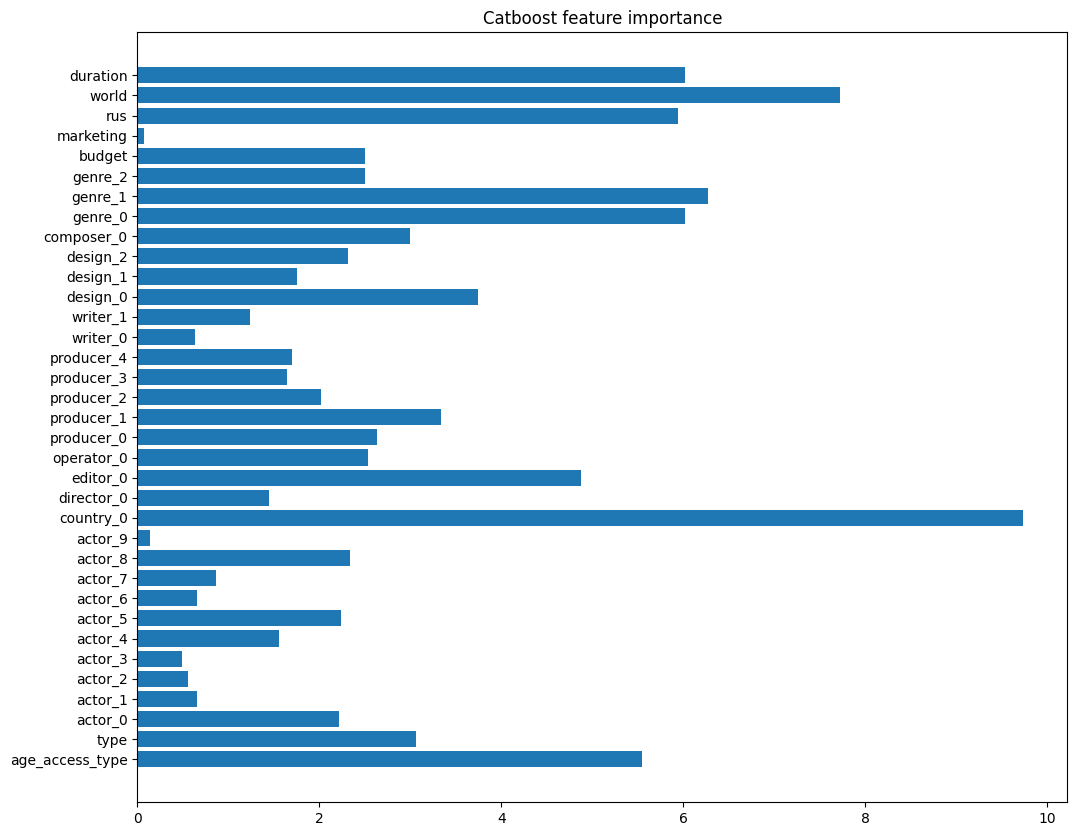

In [134]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

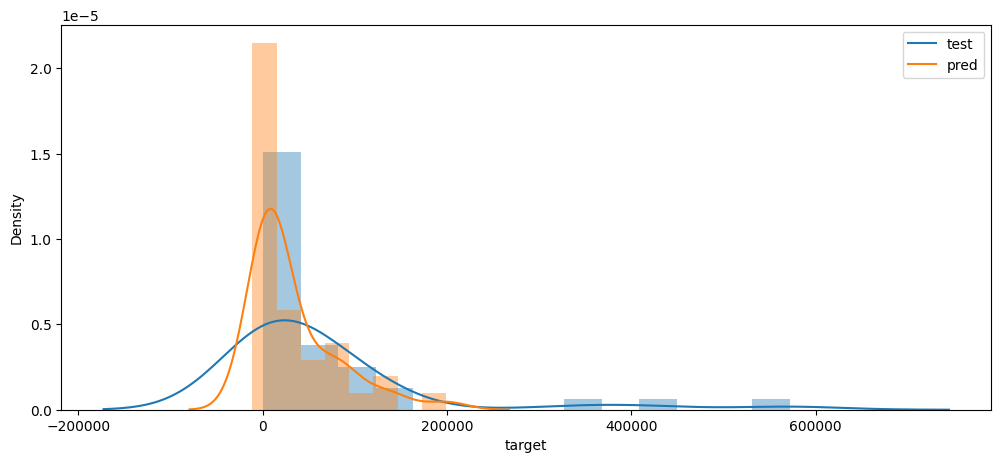

In [135]:
draw_target_distr(y_test, y_pred * 3, save_fig=False, file_name='cat_distribution')

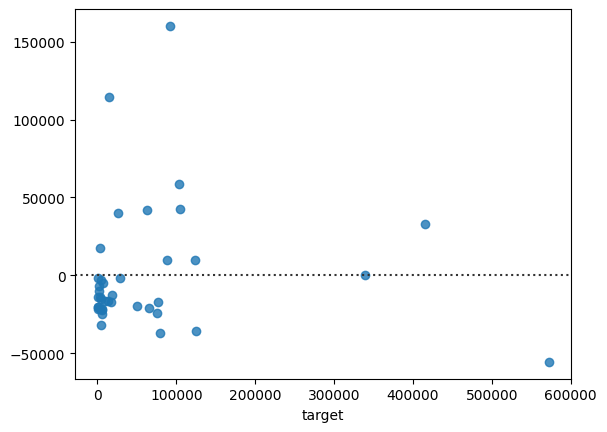

In [136]:
draw_residuals(y_test, y_pred * 3, save_fig=False)

In [137]:
len(y_pred[y_pred <= 0])

9

In [138]:
df_pr.columns

Index(['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
       'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
       'genre_1', 'genre_2', 'budget', 'marketing', 'rus', 'world', 'duration',
       'release_year', 'target', 'uid', 'name'],
      dtype='object')

In [139]:
test_review = pd.concat([X_test.merge(df_pr)[['uid', 'name', 'target']], pd.Series(y_pred * 3).apply(int)], axis=1)
test_review.columns = columns=['uid', 'name', 'target', 'y_pred']

In [140]:
test_review

uid  \
0   8ae0d185-eb68-4e24-b445-4f77a1ea4430   
1   a7979b64-cf82-4c7f-86d8-05670b07d1b0   
2   6b047b99-5cb4-4878-9a4f-b8b372b438eb   
3   ed03720e-591a-4e55-b87d-a06d14d29648   
4   1b9df53f-e556-4f00-8d1f-67b2cc74e01a   
5   ca2950a2-5243-4611-8677-bceee493fa10   
6   0a702293-b8a5-4c0e-aa50-e05bcc6feb7c   
7   29979cd4-c984-48a8-86ea-ebb7c065ec57   
8   fa45e8d6-7d96-40dc-b50d-3f012a89ecee   
9   500dec0c-d2a3-4ff3-a7c6-e2d21ea7fd9f   
10  00de4f79-d52d-4d2c-871c-e6e8432cc3df   
11  58bd705b-9358-4da6-8fac-eda72b7a401b   
12  e69d2f4d-bb65-4e7e-93e1-74da99424ae8   
13  1646f7cb-d66f-4898-af75-7d7c4fc69cc7   
14  5bd9b8c0-b482-4953-951a-813985e55e2d   
15  2fe0e352-1706-4e22-89d2-745353650492   
16  3eed9149-4311-4f23-ad37-e0985cae8cc8   
17  f02bc785-71a0-44cc-b6d6-ee2360a1c50f   
18  5a6fb345-61d7-456a-8082-e23825827ed0   
19  50adaca1-09c0-41e9-b6cc-b9200c734661   
20  a2e334ee-4c0d-4536-ad11-2b0dbe7e6394   
21  bd9a6edd-9eba-43c5-a053-4eca388798a5   
22  ea82e1c1-d44b-4516-a177-330adcf7c980   
23  36d9d568-75d0-414d-9765-25bf72c6362f   
24  9ae35927-93e3-4a40-870f-a998abbeaa9f   
25  b16d82b3-c983-4044-a0e0-304ca51b4df7   
26  2abb6b0f-2b90-409e-a70f-118df477b3f3   
27  5f6f9065-06b3-43f6-81bf-51cf9a605097   
28  9ef91a8f-fc4a-4154-a340-4723547040d2   
29  02eaefe0-296d-4e6f-b52f-2e2507d07103   
30  a8749d17-85fc-4ccf-ba56-75991c3a9da4   
31  a6ae6cdf-6e51-4069-9bdd-94daf31b74e1   
32  4badfd1c-5af4-414a-b813-8037256d8d8a   
33  9c0073b6-3430-4672-b16c-c5d8f8fa18fd   
34  19a61cc3-65ff-46ce-bf43-29c24a1cc9b6   
35  fecde143-2a72-4a70-8efc-188079a62f1a   
36  ee48def6-c311-4b73-a878-1a5d3d1679a3   
37  9b202b16-55bf-418a-b01d-9f0329b18790   
38  49a3d528-44c0-408e-b6fc-a1507ce7641a   

                                             name  target  y_pred  
0           Я знаю твои секреты 7. Дыхание смерти    4814    5509  
1                                        9 жизней   16955    6245  
2                          День слепого Валентина  104401   84162  
3                                          Турист    6287   -1130  
4                            Парни под прикрытием   50669   10976  
5                                  Танцы на углях    6149    -345  
6                             Тюрьма суперзлодеев   79177    -626  
7                                      Миротворец   25661   65118  
8                         Кабинет Путешественника    4553  -11148  
9                        Наш флаг означает Смерть    2230   10648  
10                               Не оставляй меня    2196   13409  
11                                     Бодибилдер     810    -287  
12                                   Первый Оскар   87976   47745  
13                    Саюки: Перезарядка — Зероин    2868   37928  
14                                           Ника   28459   24249  
15  Власть в ночном городе. Книга четвертая: Сила    3774   -1179  
16                                          Рэпер     279    5901  
17                          И снова здравствуйте!  124026   55104  
18                                     Тихие воды    9299    5169  
19                                        Флешбэк  125284   10144  
20                             Повелитель Дракона     521     -70  
21                           Мой мир. Поем вместе    3287    6751  
22                                      Два холма  102826   99744  
23                        Предпоследняя инстанция  571894   81635  
24                                  Тайна амулета    1134   -1341  
25                                     Спорт Тоша   18671   11262  
26                                         Смычок   14656  137119  
27                             Рэй Донован. Фильм    6369   -3805  
28                                        Мисс 89   13785    6492  
29                                      Приплыли!   63298   75103  
30                              Всё везде и сразу   65842   12705  
31                    Эластико: Двенадцатый игрок   75137   11322  
32                              

In [141]:

test_sample = test_review[test_review['uid'].isin(origs)]